# DC-TSS Example with PAMAP2 

In [65]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
#from TS_DEC_Linear import *


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from typing import Optional, List
from scipy.io import arff

from scipy.signal import find_peaks

## Set Parameters

In [250]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 8000
lr=0.1
pre_lr = 1.5e-3
layers = [10,8,8,3]
strides = [3,3,3,3]
batch_size = 1500

# DC-TSS hyper-parameters
window_length = 160
overlap_percent = 0.2
n_clusters = 80
window_length2 = 50



## Read Dataset

In [251]:
#selected_songs = [2,140,30056,30058,85594,120308,120194,120112,120105]
time_series = np.loadtxt("./data/PAMAP2.csv", delimiter=",")
labels = np.loadtxt("./data/PAMAP2_labels.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]


## Subsequence TS

In [252]:
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
batch_size = subsequences.shape[0]

C:\Users\Erik\AppData\Local\Temp\ipykernel_57048\358066657.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


## Set Data_loader for Neural Network?

In [253]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


data_loader = get_dataloader(data=subsequences,
                          shuffle=False,
                          batch_size=batch_size,
                          num_workers=1,
                          data_transforms=None)
torch.cuda.empty_cache()
input_shape = subsequences.shape
#torch.cuda.memory_summary(device=None, abbreviated=False)



cuda


In [254]:
inputs = torch.rand(40,160)
print(inputs.shape)
mod =  nn.Conv1d(40, 40, 10, stride=3)
out = mod(inputs)
print(out.shape)

mod =  nn.Conv1d(40, 40, 8, stride=3)
out = mod(out)
print(out.shape)

mod =  nn.Conv1d(40, 40, 8, stride=3)
out = mod(out)
print(out.shape)

mod =  nn.Conv1d(40, 40, 3, stride=3)
out = mod(out)
print(out.shape)


torch.Size([40, 160])
torch.Size([40, 51])
torch.Size([40, 15])
torch.Size([40, 3])
torch.Size([40, 1])


## Create DC-TSS model

In [255]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.to(device)


DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(40, 40, kernel_size=(3,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(3,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): ConvTranspose1d(40, 40, kernel_size=(10,), stride=(3,))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      

## Phase 1: Initialize Latent Space Mapping with 1DCNN AE

In [256]:
pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1,lr=pre_lr)


epoch 1,loss = 0.99919879
epoch 2,loss = 0.99906039
epoch 3,loss = 0.99894071
epoch 4,loss = 0.99881136
epoch 5,loss = 0.99859756
epoch 6,loss = 0.99817973
epoch 7,loss = 0.99723631
epoch 8,loss = 0.99500382
epoch 9,loss = 0.99007088
epoch 10,loss = 0.98017156
epoch 11,loss = 0.96377563
epoch 12,loss = 0.95350659
epoch 13,loss = 0.95375276
epoch 14,loss = 0.93586206
epoch 15,loss = 0.93268371
epoch 16,loss = 0.93033165
epoch 17,loss = 0.92448300
epoch 18,loss = 0.91732335
epoch 19,loss = 0.91301954
epoch 20,loss = 0.91264564
epoch 21,loss = 0.90577871
epoch 22,loss = 0.89930898
epoch 23,loss = 0.89678454
epoch 24,loss = 0.89345038
epoch 25,loss = 0.88831604
epoch 26,loss = 0.88379526
epoch 27,loss = 0.88125491
epoch 28,loss = 0.87633944
epoch 29,loss = 0.87078434
epoch 30,loss = 0.86780167
epoch 31,loss = 0.86524892
epoch 32,loss = 0.86281049
epoch 33,loss = 0.86249584
epoch 34,loss = 0.86232734
epoch 35,loss = 0.86040533
epoch 36,loss = 0.85862088
epoch 37,loss = 0.85672295
epoch 38,l

epoch 298,loss = 0.48925158
epoch 299,loss = 0.48920965
epoch 300,loss = 0.49053156
epoch 301,loss = 0.49142793
epoch 302,loss = 0.48886713
epoch 303,loss = 0.48741725
epoch 304,loss = 0.48554549
epoch 305,loss = 0.48556730
epoch 306,loss = 0.48678061
epoch 307,loss = 0.48426569
epoch 308,loss = 0.48258287
epoch 309,loss = 0.48291141
epoch 310,loss = 0.48281220
epoch 311,loss = 0.48187277
epoch 312,loss = 0.48042846
epoch 313,loss = 0.47995165
epoch 314,loss = 0.47929379
epoch 315,loss = 0.47887352
epoch 316,loss = 0.47816274
epoch 317,loss = 0.47682568
epoch 318,loss = 0.47644499
epoch 319,loss = 0.47645646
epoch 320,loss = 0.47559965
epoch 321,loss = 0.47488299
epoch 322,loss = 0.47421509
epoch 323,loss = 0.47328672
epoch 324,loss = 0.47259042
epoch 325,loss = 0.47230554
epoch 326,loss = 0.47173619
epoch 327,loss = 0.47136778
epoch 328,loss = 0.47104976
epoch 329,loss = 0.47055495
epoch 330,loss = 0.47081953
epoch 331,loss = 0.46998587
epoch 332,loss = 0.46924680
epoch 333,loss = 0.4

epoch 591,loss = 0.40037733
epoch 592,loss = 0.40002578
epoch 593,loss = 0.39930058
epoch 594,loss = 0.39879659
epoch 595,loss = 0.39872885
epoch 596,loss = 0.39884561
epoch 597,loss = 0.39872411
epoch 598,loss = 0.39842656
epoch 599,loss = 0.39819717
epoch 600,loss = 0.39811170
epoch 601,loss = 0.39813989
epoch 602,loss = 0.39819860
epoch 603,loss = 0.39800915
epoch 604,loss = 0.39819974
epoch 605,loss = 0.39887953
epoch 606,loss = 0.40085608
epoch 607,loss = 0.40097153
epoch 608,loss = 0.40112162
epoch 609,loss = 0.39908674
epoch 610,loss = 0.39692608
epoch 611,loss = 0.39641279
epoch 612,loss = 0.39759162
epoch 613,loss = 0.39880157
epoch 614,loss = 0.39773676
epoch 615,loss = 0.39606771
epoch 616,loss = 0.39596805
epoch 617,loss = 0.39657938
epoch 618,loss = 0.39620122
epoch 619,loss = 0.39538142
epoch 620,loss = 0.39523858
epoch 621,loss = 0.39527878
epoch 622,loss = 0.39494658
epoch 623,loss = 0.39463100
epoch 624,loss = 0.39473450
epoch 625,loss = 0.39471528
epoch 626,loss = 0.3

epoch 884,loss = 0.36152449
epoch 885,loss = 0.36025360
epoch 886,loss = 0.35989782
epoch 887,loss = 0.36086357
epoch 888,loss = 0.36165801
epoch 889,loss = 0.36023062
epoch 890,loss = 0.35920015
epoch 891,loss = 0.35982627
epoch 892,loss = 0.36027101
epoch 893,loss = 0.35997179
epoch 894,loss = 0.35885656
epoch 895,loss = 0.35893890
epoch 896,loss = 0.35983312
epoch 897,loss = 0.35954884
epoch 898,loss = 0.35898423
epoch 899,loss = 0.35922009
epoch 900,loss = 0.35987288
epoch 901,loss = 0.36076462
epoch 902,loss = 0.36019531
epoch 903,loss = 0.36017162
epoch 904,loss = 0.35954747
epoch 905,loss = 0.35896558
epoch 906,loss = 0.35842925
epoch 907,loss = 0.35826159
epoch 908,loss = 0.35857719
epoch 909,loss = 0.35858151
epoch 910,loss = 0.35834014
epoch 911,loss = 0.35802680
epoch 912,loss = 0.35817257
epoch 913,loss = 0.35800165
epoch 914,loss = 0.35765281
epoch 915,loss = 0.35693964
epoch 916,loss = 0.35681358
epoch 917,loss = 0.35706639
epoch 918,loss = 0.35700914
epoch 919,loss = 0.3

epoch 1171,loss = 0.33880007
epoch 1172,loss = 0.33893785
epoch 1173,loss = 0.34007791
epoch 1174,loss = 0.33977437
epoch 1175,loss = 0.33885115
epoch 1176,loss = 0.33678183
epoch 1177,loss = 0.33795527
epoch 1178,loss = 0.33898109
epoch 1179,loss = 0.33731580
epoch 1180,loss = 0.33588818
epoch 1181,loss = 0.33591369
epoch 1182,loss = 0.33646119
epoch 1183,loss = 0.33652771
epoch 1184,loss = 0.33601716
epoch 1185,loss = 0.33526394
epoch 1186,loss = 0.33480406
epoch 1187,loss = 0.33506694
epoch 1188,loss = 0.33549172
epoch 1189,loss = 0.33512276
epoch 1190,loss = 0.33461732
epoch 1191,loss = 0.33468771
epoch 1192,loss = 0.33495185
epoch 1193,loss = 0.33469915
epoch 1194,loss = 0.33437300
epoch 1195,loss = 0.33448014
epoch 1196,loss = 0.33509058
epoch 1197,loss = 0.33530873
epoch 1198,loss = 0.33563578
epoch 1199,loss = 0.33561686
epoch 1200,loss = 0.33596864


In [257]:
torch.save(deep_cluster_model.state_dict(), './PAMAP2_pretrain_example_shuffle.pth')

In [315]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.load_state_dict(torch.load('./PAMAP2_pretrain_example_shuffle.pth'))
deep_cluster_model.to(device)

DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(40, 40, kernel_size=(3,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(3,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): ConvTranspose1d(40, 40, kernel_size=(10,), stride=(3,))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      

## Phase 2: Refine Latent Space and Find Clusters

In [316]:
cluster_assignments = refine_clusters(100, data_loader, deep_cluster_model, device, epochs2, batch_size, lr, 0.0, 1)


Initializing cluster centers with k-means. number of clusters 100
torch.Size([2940, 40, 160])
1.0
Epoch 1:   loss= 0.48429
Epoch 2:   loss= 0.48443
Epoch 3:   loss= 0.49672
Epoch 4:   loss= 0.48685
Epoch 5:   loss= 0.48943
Epoch 6:   loss= 0.49014
Epoch 7:   loss= 0.49613
Epoch 8:   loss= 0.48568
Epoch 9:   loss= 0.48755
Epoch 10:   loss= 0.48821
Epoch 11:   loss= 0.49124
Epoch 12:   loss= 0.492
Epoch 13:   loss= 0.49374
Epoch 14:   loss= 0.49494
Epoch 15:   loss= 0.49339
Epoch 16:   loss= 0.49371
Epoch 17:   loss= 0.49388
Epoch 18:   loss= 0.49475
Epoch 19:   loss= 0.49675
Epoch 20:   loss= 0.49659
Epoch 21:   loss= 0.49829
Epoch 22:   loss= 0.49662
Epoch 23:   loss= 0.49686
Epoch 24:   loss= 0.49649
Epoch 25:   loss= 0.49734
Epoch 26:   loss= 0.49853
Epoch 27:   loss= 0.49978
Epoch 28:   loss= 0.50095
Epoch 29:   loss= 0.50216
Epoch 30:   loss= 0.50306
Epoch 31:   loss= 0.50341
Epoch 32:   loss= 0.50402
Epoch 33:   loss= 0.50353
Epoch 34:   loss= 0.50452
Epoch 35:   loss= 0.50532
Epo

Epoch 310:   loss= 0.49981
Epoch 311:   loss= 0.49972
Epoch 312:   loss= 0.49964
Epoch 313:   loss= 0.49955
Epoch 314:   loss= 0.49947
Epoch 315:   loss= 0.49938
Epoch 316:   loss= 0.4993
Epoch 317:   loss= 0.49921
Epoch 318:   loss= 0.49912
Epoch 319:   loss= 0.49903
Epoch 320:   loss= 0.49895
Epoch 321:   loss= 0.49886
Epoch 322:   loss= 0.49878
Epoch 323:   loss= 0.49869
Epoch 324:   loss= 0.49861
Epoch 325:   loss= 0.49852
Epoch 326:   loss= 0.49843
Epoch 327:   loss= 0.49834
Epoch 328:   loss= 0.49826
Epoch 329:   loss= 0.49817
Epoch 330:   loss= 0.49808
Epoch 331:   loss= 0.49799
Epoch 332:   loss= 0.49791
Epoch 333:   loss= 0.49782
Epoch 334:   loss= 0.49773
Epoch 335:   loss= 0.49764
Epoch 336:   loss= 0.49755
Epoch 337:   loss= 0.49746
Epoch 338:   loss= 0.49737
Epoch 339:   loss= 0.49728
Epoch 340:   loss= 0.49719
Epoch 341:   loss= 0.4971
Epoch 342:   loss= 0.49701
Epoch 343:   loss= 0.49692
Epoch 344:   loss= 0.49683
Epoch 345:   loss= 0.49674
Epoch 346:   loss= 0.49665
Epo

Epoch 624:   loss= 0.4799
Epoch 625:   loss= 0.47986
Epoch 626:   loss= 0.4798
Epoch 627:   loss= 0.47976
Epoch 628:   loss= 0.4797
Epoch 629:   loss= 0.47966
Epoch 630:   loss= 0.4796
Epoch 631:   loss= 0.47956
Epoch 632:   loss= 0.4795
Epoch 633:   loss= 0.47946
Epoch 634:   loss= 0.47941
Epoch 635:   loss= 0.47936
Epoch 636:   loss= 0.47931
Epoch 637:   loss= 0.47926
Epoch 638:   loss= 0.47921
Epoch 639:   loss= 0.47917
Epoch 640:   loss= 0.47911
Epoch 641:   loss= 0.47907
Epoch 642:   loss= 0.47901
Epoch 643:   loss= 0.47897
Epoch 644:   loss= 0.47892
Epoch 645:   loss= 0.47887
Epoch 646:   loss= 0.47882
Epoch 647:   loss= 0.47878
Epoch 648:   loss= 0.47872
Epoch 649:   loss= 0.47868
Epoch 650:   loss= 0.47862
Epoch 651:   loss= 0.47858
Epoch 652:   loss= 0.47853
Epoch 653:   loss= 0.47848
Epoch 654:   loss= 0.47843
Epoch 655:   loss= 0.47839
Epoch 656:   loss= 0.47833
Epoch 657:   loss= 0.47829
Epoch 658:   loss= 0.47823
Epoch 659:   loss= 0.47819
Epoch 660:   loss= 0.47813
Epoch 

Epoch 933:   loss= 0.46708
Epoch 934:   loss= 0.46706
Epoch 935:   loss= 0.46705
Epoch 936:   loss= 0.46703
Epoch 937:   loss= 0.46702
Epoch 938:   loss= 0.467
Epoch 939:   loss= 0.46699
Epoch 940:   loss= 0.46697
Epoch 941:   loss= 0.46696
Epoch 942:   loss= 0.46694
Epoch 943:   loss= 0.46693
Epoch 944:   loss= 0.46691
Epoch 945:   loss= 0.4669
Epoch 946:   loss= 0.46687
Epoch 947:   loss= 0.46686
Epoch 948:   loss= 0.46683
Epoch 949:   loss= 0.46682
Epoch 950:   loss= 0.46679
Epoch 951:   loss= 0.46678
Epoch 952:   loss= 0.46675
Epoch 953:   loss= 0.46674
Epoch 954:   loss= 0.46671
Epoch 955:   loss= 0.46669
Epoch 956:   loss= 0.46666
Epoch 957:   loss= 0.46665
Epoch 958:   loss= 0.46661
Epoch 959:   loss= 0.4666
Epoch 960:   loss= 0.46657
Epoch 961:   loss= 0.46655
Epoch 962:   loss= 0.46652
Epoch 963:   loss= 0.4665
Epoch 964:   loss= 0.46647
Epoch 965:   loss= 0.46645
Epoch 966:   loss= 0.46642
Epoch 967:   loss= 0.4664
Epoch 968:   loss= 0.46636
Epoch 969:   loss= 0.46635
Epoch 9

Epoch 1239:   loss= 0.45867
Epoch 1240:   loss= 0.45864
Epoch 1241:   loss= 0.45862
Epoch 1242:   loss= 0.45859
Epoch 1243:   loss= 0.45857
Epoch 1244:   loss= 0.45854
Epoch 1245:   loss= 0.45852
Epoch 1246:   loss= 0.45849
Epoch 1247:   loss= 0.45847
Epoch 1248:   loss= 0.45844
Epoch 1249:   loss= 0.45842
Epoch 1250:   loss= 0.45839
Epoch 1251:   loss= 0.45837
Epoch 1252:   loss= 0.45833
Epoch 1253:   loss= 0.45832
Epoch 1254:   loss= 0.45828
Epoch 1255:   loss= 0.45826
Epoch 1256:   loss= 0.45823
Epoch 1257:   loss= 0.45821
Epoch 1258:   loss= 0.45818
Epoch 1259:   loss= 0.45816
Epoch 1260:   loss= 0.45813
Epoch 1261:   loss= 0.45811
Epoch 1262:   loss= 0.45808
Epoch 1263:   loss= 0.45806
Epoch 1264:   loss= 0.45803
Epoch 1265:   loss= 0.45801
Epoch 1266:   loss= 0.45798
Epoch 1267:   loss= 0.45796
Epoch 1268:   loss= 0.45793
Epoch 1269:   loss= 0.45791
Epoch 1270:   loss= 0.45788
Epoch 1271:   loss= 0.45786
Epoch 1272:   loss= 0.45783
Epoch 1273:   loss= 0.45781
Epoch 1274:   loss= 

Epoch 1538:   loss= 0.45183
Epoch 1539:   loss= 0.45181
Epoch 1540:   loss= 0.45178
Epoch 1541:   loss= 0.45177
Epoch 1542:   loss= 0.45174
Epoch 1543:   loss= 0.45173
Epoch 1544:   loss= 0.4517
Epoch 1545:   loss= 0.45169
Epoch 1546:   loss= 0.45166
Epoch 1547:   loss= 0.45165
Epoch 1548:   loss= 0.45162
Epoch 1549:   loss= 0.45161
Epoch 1550:   loss= 0.45158
Epoch 1551:   loss= 0.45156
Epoch 1552:   loss= 0.45154
Epoch 1553:   loss= 0.45152
Epoch 1554:   loss= 0.4515
Epoch 1555:   loss= 0.45148
Epoch 1556:   loss= 0.45146
Epoch 1557:   loss= 0.45144
Epoch 1558:   loss= 0.45142
Epoch 1559:   loss= 0.4514
Epoch 1560:   loss= 0.45138
Epoch 1561:   loss= 0.45136
Epoch 1562:   loss= 0.45134
Epoch 1563:   loss= 0.45132
Epoch 1564:   loss= 0.45129
Epoch 1565:   loss= 0.45128
Epoch 1566:   loss= 0.45125
Epoch 1567:   loss= 0.45124
Epoch 1568:   loss= 0.45121
Epoch 1569:   loss= 0.4512
Epoch 1570:   loss= 0.45117
Epoch 1571:   loss= 0.45116
Epoch 1572:   loss= 0.45113
Epoch 1573:   loss= 0.45

Epoch 1836:   loss= 0.44622
Epoch 1837:   loss= 0.4462
Epoch 1838:   loss= 0.44618
Epoch 1839:   loss= 0.44617
Epoch 1840:   loss= 0.44615
Epoch 1841:   loss= 0.44613
Epoch 1842:   loss= 0.44611
Epoch 1843:   loss= 0.4461
Epoch 1844:   loss= 0.44608
Epoch 1845:   loss= 0.44606
Epoch 1846:   loss= 0.44604
Epoch 1847:   loss= 0.44603
Epoch 1848:   loss= 0.44601
Epoch 1849:   loss= 0.44599
Epoch 1850:   loss= 0.44597
Epoch 1851:   loss= 0.44596
Epoch 1852:   loss= 0.44594
Epoch 1853:   loss= 0.44593
Epoch 1854:   loss= 0.4459
Epoch 1855:   loss= 0.44589
Epoch 1856:   loss= 0.44587
Epoch 1857:   loss= 0.44586
Epoch 1858:   loss= 0.44583
Epoch 1859:   loss= 0.44582
Epoch 1860:   loss= 0.4458
Epoch 1861:   loss= 0.44579
Epoch 1862:   loss= 0.44576
Epoch 1863:   loss= 0.44575
Epoch 1864:   loss= 0.44573
Epoch 1865:   loss= 0.44572
Epoch 1866:   loss= 0.4457
Epoch 1867:   loss= 0.44568
Epoch 1868:   loss= 0.44566
Epoch 1869:   loss= 0.44565
Epoch 1870:   loss= 0.44563
Epoch 1871:   loss= 0.445

Epoch 2131:   loss= 0.44146
Epoch 2132:   loss= 0.44144
Epoch 2133:   loss= 0.44143
Epoch 2134:   loss= 0.44141
Epoch 2135:   loss= 0.4414
Epoch 2136:   loss= 0.44138
Epoch 2137:   loss= 0.44137
Epoch 2138:   loss= 0.44135
Epoch 2139:   loss= 0.44134
Epoch 2140:   loss= 0.44132
Epoch 2141:   loss= 0.44131
Epoch 2142:   loss= 0.44129
Epoch 2143:   loss= 0.44128
Epoch 2144:   loss= 0.44126
Epoch 2145:   loss= 0.44125
Epoch 2146:   loss= 0.44123
Epoch 2147:   loss= 0.44122
Epoch 2148:   loss= 0.4412
Epoch 2149:   loss= 0.44119
Epoch 2150:   loss= 0.44117
Epoch 2151:   loss= 0.44116
Epoch 2152:   loss= 0.44114
Epoch 2153:   loss= 0.44113
Epoch 2154:   loss= 0.44111
Epoch 2155:   loss= 0.4411
Epoch 2156:   loss= 0.44108
Epoch 2157:   loss= 0.44107
Epoch 2158:   loss= 0.44105
Epoch 2159:   loss= 0.44104
Epoch 2160:   loss= 0.44102
Epoch 2161:   loss= 0.44101
Epoch 2162:   loss= 0.44099
Epoch 2163:   loss= 0.44098
Epoch 2164:   loss= 0.44096
Epoch 2165:   loss= 0.44095
Epoch 2166:   loss= 0.4

Epoch 2433:   loss= 0.43751
Epoch 2434:   loss= 0.43749
Epoch 2435:   loss= 0.43748
Epoch 2436:   loss= 0.43747
Epoch 2437:   loss= 0.43746
Epoch 2438:   loss= 0.43744
Epoch 2439:   loss= 0.43743
Epoch 2440:   loss= 0.43742
Epoch 2441:   loss= 0.4374
Epoch 2442:   loss= 0.43739
Epoch 2443:   loss= 0.43738
Epoch 2444:   loss= 0.43736
Epoch 2445:   loss= 0.43735
Epoch 2446:   loss= 0.43734
Epoch 2447:   loss= 0.43733
Epoch 2448:   loss= 0.43731
Epoch 2449:   loss= 0.4373
Epoch 2450:   loss= 0.43729
Epoch 2451:   loss= 0.43727
Epoch 2452:   loss= 0.43726
Epoch 2453:   loss= 0.43725
Epoch 2454:   loss= 0.43723
Epoch 2455:   loss= 0.43722
Epoch 2456:   loss= 0.43721
Epoch 2457:   loss= 0.43719
Epoch 2458:   loss= 0.43718
Epoch 2459:   loss= 0.43717
Epoch 2460:   loss= 0.43715
Epoch 2461:   loss= 0.43714
Epoch 2462:   loss= 0.43712
Epoch 2463:   loss= 0.43711
Epoch 2464:   loss= 0.4371
Epoch 2465:   loss= 0.43709
Epoch 2466:   loss= 0.43707
Epoch 2467:   loss= 0.43706
Epoch 2468:   loss= 0.4

Epoch 2729:   loss= 0.43368
Epoch 2730:   loss= 0.43367
Epoch 2731:   loss= 0.43366
Epoch 2732:   loss= 0.43365
Epoch 2733:   loss= 0.43364
Epoch 2734:   loss= 0.43363
Epoch 2735:   loss= 0.43361
Epoch 2736:   loss= 0.43361
Epoch 2737:   loss= 0.43359
Epoch 2738:   loss= 0.43359
Epoch 2739:   loss= 0.43357
Epoch 2740:   loss= 0.43356
Epoch 2741:   loss= 0.43355
Epoch 2742:   loss= 0.43354
Epoch 2743:   loss= 0.43353
Epoch 2744:   loss= 0.43352
Epoch 2745:   loss= 0.43351
Epoch 2746:   loss= 0.4335
Epoch 2747:   loss= 0.43348
Epoch 2748:   loss= 0.43348
Epoch 2749:   loss= 0.43346
Epoch 2750:   loss= 0.43346
Epoch 2751:   loss= 0.43344
Epoch 2752:   loss= 0.43343
Epoch 2753:   loss= 0.43342
Epoch 2754:   loss= 0.43341
Epoch 2755:   loss= 0.4334
Epoch 2756:   loss= 0.43339
Epoch 2757:   loss= 0.43338
Epoch 2758:   loss= 0.43337
Epoch 2759:   loss= 0.43335
Epoch 2760:   loss= 0.43335
Epoch 2761:   loss= 0.43333
Epoch 2762:   loss= 0.43333
Epoch 2763:   loss= 0.43331
Epoch 2764:   loss= 0.

Epoch 3028:   loss= 0.4304
Epoch 3029:   loss= 0.43039
Epoch 3030:   loss= 0.43038
Epoch 3031:   loss= 0.43037
Epoch 3032:   loss= 0.43036
Epoch 3033:   loss= 0.43035
Epoch 3034:   loss= 0.43034
Epoch 3035:   loss= 0.43032
Epoch 3036:   loss= 0.43032
Epoch 3037:   loss= 0.4303
Epoch 3038:   loss= 0.4303
Epoch 3039:   loss= 0.43028
Epoch 3040:   loss= 0.43027
Epoch 3041:   loss= 0.43026
Epoch 3042:   loss= 0.43025
Epoch 3043:   loss= 0.43024
Epoch 3044:   loss= 0.43023
Epoch 3045:   loss= 0.43022
Epoch 3046:   loss= 0.43021
Epoch 3047:   loss= 0.43019
Epoch 3048:   loss= 0.43019
Epoch 3049:   loss= 0.43017
Epoch 3050:   loss= 0.43017
Epoch 3051:   loss= 0.43015
Epoch 3052:   loss= 0.43014
Epoch 3053:   loss= 0.43013
Epoch 3054:   loss= 0.43012
Epoch 3055:   loss= 0.43011
Epoch 3056:   loss= 0.4301
Epoch 3057:   loss= 0.43009
Epoch 3058:   loss= 0.43008
Epoch 3059:   loss= 0.43006
Epoch 3060:   loss= 0.43006
Epoch 3061:   loss= 0.43004
Epoch 3062:   loss= 0.43004
Epoch 3063:   loss= 0.43

Epoch 3325:   loss= 0.42726
Epoch 3326:   loss= 0.42725
Epoch 3327:   loss= 0.42724
Epoch 3328:   loss= 0.42723
Epoch 3329:   loss= 0.42722
Epoch 3330:   loss= 0.42721
Epoch 3331:   loss= 0.4272
Epoch 3332:   loss= 0.42719
Epoch 3333:   loss= 0.42718
Epoch 3334:   loss= 0.42717
Epoch 3335:   loss= 0.42715
Epoch 3336:   loss= 0.42715
Epoch 3337:   loss= 0.42713
Epoch 3338:   loss= 0.42713
Epoch 3339:   loss= 0.42711
Epoch 3340:   loss= 0.42711
Epoch 3341:   loss= 0.42709
Epoch 3342:   loss= 0.42709
Epoch 3343:   loss= 0.42707
Epoch 3344:   loss= 0.42707
Epoch 3345:   loss= 0.42705
Epoch 3346:   loss= 0.42705
Epoch 3347:   loss= 0.42703
Epoch 3348:   loss= 0.42703
Epoch 3349:   loss= 0.42701
Epoch 3350:   loss= 0.42701
Epoch 3351:   loss= 0.42699
Epoch 3352:   loss= 0.42699
Epoch 3353:   loss= 0.42697
Epoch 3354:   loss= 0.42696
Epoch 3355:   loss= 0.42695
Epoch 3356:   loss= 0.42694
Epoch 3357:   loss= 0.42693
Epoch 3358:   loss= 0.42692
Epoch 3359:   loss= 0.42691
Epoch 3360:   loss= 0

Epoch 3627:   loss= 0.42427
Epoch 3628:   loss= 0.42427
Epoch 3629:   loss= 0.42426
Epoch 3630:   loss= 0.42425
Epoch 3631:   loss= 0.42424
Epoch 3632:   loss= 0.42423
Epoch 3633:   loss= 0.42422
Epoch 3634:   loss= 0.42421
Epoch 3635:   loss= 0.4242
Epoch 3636:   loss= 0.42419
Epoch 3637:   loss= 0.42418
Epoch 3638:   loss= 0.42417
Epoch 3639:   loss= 0.42416
Epoch 3640:   loss= 0.42415
Epoch 3641:   loss= 0.42414
Epoch 3642:   loss= 0.42414
Epoch 3643:   loss= 0.42412
Epoch 3644:   loss= 0.42412
Epoch 3645:   loss= 0.4241
Epoch 3646:   loss= 0.4241
Epoch 3647:   loss= 0.42408
Epoch 3648:   loss= 0.42408
Epoch 3649:   loss= 0.42407
Epoch 3650:   loss= 0.42406
Epoch 3651:   loss= 0.42405
Epoch 3652:   loss= 0.42404
Epoch 3653:   loss= 0.42403
Epoch 3654:   loss= 0.42402
Epoch 3655:   loss= 0.42401
Epoch 3656:   loss= 0.424
Epoch 3657:   loss= 0.42399
Epoch 3658:   loss= 0.42398
Epoch 3659:   loss= 0.42397
Epoch 3660:   loss= 0.42397
Epoch 3661:   loss= 0.42395
Epoch 3662:   loss= 0.423

Epoch 3929:   loss= 0.4216
Epoch 3930:   loss= 0.42159
Epoch 3931:   loss= 0.42158
Epoch 3932:   loss= 0.42158
Epoch 3933:   loss= 0.42157
Epoch 3934:   loss= 0.42156
Epoch 3935:   loss= 0.42155
Epoch 3936:   loss= 0.42155
Epoch 3937:   loss= 0.42153
Epoch 3938:   loss= 0.42153
Epoch 3939:   loss= 0.42152
Epoch 3940:   loss= 0.42151
Epoch 3941:   loss= 0.4215
Epoch 3942:   loss= 0.4215
Epoch 3943:   loss= 0.42149
Epoch 3944:   loss= 0.42148
Epoch 3945:   loss= 0.42147
Epoch 3946:   loss= 0.42147
Epoch 3947:   loss= 0.42145
Epoch 3948:   loss= 0.42145
Epoch 3949:   loss= 0.42144
Epoch 3950:   loss= 0.42143
Epoch 3951:   loss= 0.42142
Epoch 3952:   loss= 0.42142
Epoch 3953:   loss= 0.42141
Epoch 3954:   loss= 0.4214
Epoch 3955:   loss= 0.42139
Epoch 3956:   loss= 0.42139
Epoch 3957:   loss= 0.42137
Epoch 3958:   loss= 0.42137
Epoch 3959:   loss= 0.42136
Epoch 3960:   loss= 0.42135
Epoch 3961:   loss= 0.42134
Epoch 3962:   loss= 0.42134
Epoch 3963:   loss= 0.42133
Epoch 3964:   loss= 0.42

Epoch 4226:   loss= 0.41923
Epoch 4227:   loss= 0.41922
Epoch 4228:   loss= 0.41921
Epoch 4229:   loss= 0.4192
Epoch 4230:   loss= 0.4192
Epoch 4231:   loss= 0.41919
Epoch 4232:   loss= 0.41918
Epoch 4233:   loss= 0.41917
Epoch 4234:   loss= 0.41916
Epoch 4235:   loss= 0.41915
Epoch 4236:   loss= 0.41915
Epoch 4237:   loss= 0.41914
Epoch 4238:   loss= 0.41913
Epoch 4239:   loss= 0.41912
Epoch 4240:   loss= 0.41911
Epoch 4241:   loss= 0.4191
Epoch 4242:   loss= 0.4191
Epoch 4243:   loss= 0.41909
Epoch 4244:   loss= 0.41908
Epoch 4245:   loss= 0.41907
Epoch 4246:   loss= 0.41906
Epoch 4247:   loss= 0.41905
Epoch 4248:   loss= 0.41905
Epoch 4249:   loss= 0.41903
Epoch 4250:   loss= 0.41903
Epoch 4251:   loss= 0.41902
Epoch 4252:   loss= 0.41901
Epoch 4253:   loss= 0.419
Epoch 4254:   loss= 0.41899
Epoch 4255:   loss= 0.41898
Epoch 4256:   loss= 0.41897
Epoch 4257:   loss= 0.41896
Epoch 4258:   loss= 0.41895
Epoch 4259:   loss= 0.41894
Epoch 4260:   loss= 0.41893
Epoch 4261:   loss= 0.4189

Epoch 4521:   loss= 0.41699
Epoch 4522:   loss= 0.41699
Epoch 4523:   loss= 0.41698
Epoch 4524:   loss= 0.41697
Epoch 4525:   loss= 0.41696
Epoch 4526:   loss= 0.41696
Epoch 4527:   loss= 0.41695
Epoch 4528:   loss= 0.41694
Epoch 4529:   loss= 0.41693
Epoch 4530:   loss= 0.41693
Epoch 4531:   loss= 0.41692
Epoch 4532:   loss= 0.41691
Epoch 4533:   loss= 0.4169
Epoch 4534:   loss= 0.4169
Epoch 4535:   loss= 0.41689
Epoch 4536:   loss= 0.41689
Epoch 4537:   loss= 0.41688
Epoch 4538:   loss= 0.41687
Epoch 4539:   loss= 0.41686
Epoch 4540:   loss= 0.41686
Epoch 4541:   loss= 0.41685
Epoch 4542:   loss= 0.41685
Epoch 4543:   loss= 0.41684
Epoch 4544:   loss= 0.41683
Epoch 4545:   loss= 0.41683
Epoch 4546:   loss= 0.41682
Epoch 4547:   loss= 0.41681
Epoch 4548:   loss= 0.41681
Epoch 4549:   loss= 0.4168
Epoch 4550:   loss= 0.4168
Epoch 4551:   loss= 0.41679
Epoch 4552:   loss= 0.41679
Epoch 4553:   loss= 0.41678
Epoch 4554:   loss= 0.41677
Epoch 4555:   loss= 0.41677
Epoch 4556:   loss= 0.41

Epoch 4821:   loss= 0.41489
Epoch 4822:   loss= 0.41489
Epoch 4823:   loss= 0.41488
Epoch 4824:   loss= 0.41487
Epoch 4825:   loss= 0.41486
Epoch 4826:   loss= 0.41486
Epoch 4827:   loss= 0.41485
Epoch 4828:   loss= 0.41485
Epoch 4829:   loss= 0.41484
Epoch 4830:   loss= 0.41483
Epoch 4831:   loss= 0.41482
Epoch 4832:   loss= 0.41482
Epoch 4833:   loss= 0.41481
Epoch 4834:   loss= 0.4148
Epoch 4835:   loss= 0.41479
Epoch 4836:   loss= 0.41479
Epoch 4837:   loss= 0.41478
Epoch 4838:   loss= 0.41477
Epoch 4839:   loss= 0.41476
Epoch 4840:   loss= 0.41476
Epoch 4841:   loss= 0.41475
Epoch 4842:   loss= 0.41475
Epoch 4843:   loss= 0.41474
Epoch 4844:   loss= 0.41473
Epoch 4845:   loss= 0.41472
Epoch 4846:   loss= 0.41472
Epoch 4847:   loss= 0.41471
Epoch 4848:   loss= 0.4147
Epoch 4849:   loss= 0.41469
Epoch 4850:   loss= 0.41469
Epoch 4851:   loss= 0.41468
Epoch 4852:   loss= 0.41467
Epoch 4853:   loss= 0.41466
Epoch 4854:   loss= 0.41466
Epoch 4855:   loss= 0.41465
Epoch 4856:   loss= 0.

Epoch 5121:   loss= 0.41289
Epoch 5122:   loss= 0.41289
Epoch 5123:   loss= 0.41288
Epoch 5124:   loss= 0.41287
Epoch 5125:   loss= 0.41286
Epoch 5126:   loss= 0.41286
Epoch 5127:   loss= 0.41285
Epoch 5128:   loss= 0.41285
Epoch 5129:   loss= 0.41284
Epoch 5130:   loss= 0.41283
Epoch 5131:   loss= 0.41282
Epoch 5132:   loss= 0.41282
Epoch 5133:   loss= 0.41281
Epoch 5134:   loss= 0.4128
Epoch 5135:   loss= 0.4128
Epoch 5136:   loss= 0.41279
Epoch 5137:   loss= 0.41278
Epoch 5138:   loss= 0.41278
Epoch 5139:   loss= 0.41277
Epoch 5140:   loss= 0.41276
Epoch 5141:   loss= 0.41275
Epoch 5142:   loss= 0.41275
Epoch 5143:   loss= 0.41274
Epoch 5144:   loss= 0.41273
Epoch 5145:   loss= 0.41272
Epoch 5146:   loss= 0.41272
Epoch 5147:   loss= 0.41271
Epoch 5148:   loss= 0.4127
Epoch 5149:   loss= 0.41269
Epoch 5150:   loss= 0.41269
Epoch 5151:   loss= 0.41268
Epoch 5152:   loss= 0.41267
Epoch 5153:   loss= 0.41266
Epoch 5154:   loss= 0.41265
Epoch 5155:   loss= 0.41264
Epoch 5156:   loss= 0.4

Epoch 5421:   loss= 0.41103
Epoch 5422:   loss= 0.41102
Epoch 5423:   loss= 0.41102
Epoch 5424:   loss= 0.41101
Epoch 5425:   loss= 0.411
Epoch 5426:   loss= 0.411
Epoch 5427:   loss= 0.41099
Epoch 5428:   loss= 0.41099
Epoch 5429:   loss= 0.41098
Epoch 5430:   loss= 0.41097
Epoch 5431:   loss= 0.41096
Epoch 5432:   loss= 0.41096
Epoch 5433:   loss= 0.41095
Epoch 5434:   loss= 0.41095
Epoch 5435:   loss= 0.41094
Epoch 5436:   loss= 0.41093
Epoch 5437:   loss= 0.41092
Epoch 5438:   loss= 0.41092
Epoch 5439:   loss= 0.41091
Epoch 5440:   loss= 0.41091
Epoch 5441:   loss= 0.4109
Epoch 5442:   loss= 0.41089
Epoch 5443:   loss= 0.41089
Epoch 5444:   loss= 0.41088
Epoch 5445:   loss= 0.41087
Epoch 5446:   loss= 0.41087
Epoch 5447:   loss= 0.41086
Epoch 5448:   loss= 0.41085
Epoch 5449:   loss= 0.41085
Epoch 5450:   loss= 0.41084
Epoch 5451:   loss= 0.41083
Epoch 5452:   loss= 0.41083
Epoch 5453:   loss= 0.41082
Epoch 5454:   loss= 0.41082
Epoch 5455:   loss= 0.41081
Epoch 5456:   loss= 0.410

Epoch 5718:   loss= 0.40924
Epoch 5719:   loss= 0.40923
Epoch 5720:   loss= 0.40923
Epoch 5721:   loss= 0.40922
Epoch 5722:   loss= 0.40922
Epoch 5723:   loss= 0.40921
Epoch 5724:   loss= 0.40921
Epoch 5725:   loss= 0.4092
Epoch 5726:   loss= 0.40919
Epoch 5727:   loss= 0.40919
Epoch 5728:   loss= 0.40918
Epoch 5729:   loss= 0.40918
Epoch 5730:   loss= 0.40917
Epoch 5731:   loss= 0.40916
Epoch 5732:   loss= 0.40916
Epoch 5733:   loss= 0.40915
Epoch 5734:   loss= 0.40915
Epoch 5735:   loss= 0.40914
Epoch 5736:   loss= 0.40914
Epoch 5737:   loss= 0.40913
Epoch 5738:   loss= 0.40912
Epoch 5739:   loss= 0.40911
Epoch 5740:   loss= 0.40911
Epoch 5741:   loss= 0.4091
Epoch 5742:   loss= 0.4091
Epoch 5743:   loss= 0.40909
Epoch 5744:   loss= 0.40909
Epoch 5745:   loss= 0.40908
Epoch 5746:   loss= 0.40907
Epoch 5747:   loss= 0.40906
Epoch 5748:   loss= 0.40906
Epoch 5749:   loss= 0.40905
Epoch 5750:   loss= 0.40905
Epoch 5751:   loss= 0.40904
Epoch 5752:   loss= 0.40903
Epoch 5753:   loss= 0.4

Epoch 6015:   loss= 0.4074
Epoch 6016:   loss= 0.40739
Epoch 6017:   loss= 0.40738
Epoch 6018:   loss= 0.40738
Epoch 6019:   loss= 0.40737
Epoch 6020:   loss= 0.40737
Epoch 6021:   loss= 0.40736
Epoch 6022:   loss= 0.40736
Epoch 6023:   loss= 0.40735
Epoch 6024:   loss= 0.40734
Epoch 6025:   loss= 0.40734
Epoch 6026:   loss= 0.40733
Epoch 6027:   loss= 0.40733
Epoch 6028:   loss= 0.40732
Epoch 6029:   loss= 0.40731
Epoch 6030:   loss= 0.40731
Epoch 6031:   loss= 0.4073
Epoch 6032:   loss= 0.4073
Epoch 6033:   loss= 0.40729
Epoch 6034:   loss= 0.40729
Epoch 6035:   loss= 0.40728
Epoch 6036:   loss= 0.40728
Epoch 6037:   loss= 0.40727
Epoch 6038:   loss= 0.40727
Epoch 6039:   loss= 0.40726
Epoch 6040:   loss= 0.40726
Epoch 6041:   loss= 0.40725
Epoch 6042:   loss= 0.40725
Epoch 6043:   loss= 0.40724
Epoch 6044:   loss= 0.40724
Epoch 6045:   loss= 0.40724
Epoch 6046:   loss= 0.40723
Epoch 6047:   loss= 0.40723
Epoch 6048:   loss= 0.40722
Epoch 6049:   loss= 0.40722
Epoch 6050:   loss= 0.4

Epoch 6310:   loss= 0.40564
Epoch 6311:   loss= 0.40563
Epoch 6312:   loss= 0.40563
Epoch 6313:   loss= 0.40562
Epoch 6314:   loss= 0.40562
Epoch 6315:   loss= 0.40561
Epoch 6316:   loss= 0.40561
Epoch 6317:   loss= 0.4056
Epoch 6318:   loss= 0.40559
Epoch 6319:   loss= 0.40559
Epoch 6320:   loss= 0.40558
Epoch 6321:   loss= 0.40557
Epoch 6322:   loss= 0.40557
Epoch 6323:   loss= 0.40556
Epoch 6324:   loss= 0.40556
Epoch 6325:   loss= 0.40555
Epoch 6326:   loss= 0.40554
Epoch 6327:   loss= 0.40554
Epoch 6328:   loss= 0.40553
Epoch 6329:   loss= 0.40552
Epoch 6330:   loss= 0.40552
Epoch 6331:   loss= 0.40551
Epoch 6332:   loss= 0.40551
Epoch 6333:   loss= 0.4055
Epoch 6334:   loss= 0.4055
Epoch 6335:   loss= 0.40549
Epoch 6336:   loss= 0.40548
Epoch 6337:   loss= 0.40547
Epoch 6338:   loss= 0.40547
Epoch 6339:   loss= 0.40546
Epoch 6340:   loss= 0.40546
Epoch 6341:   loss= 0.40545
Epoch 6342:   loss= 0.40545
Epoch 6343:   loss= 0.40544
Epoch 6344:   loss= 0.40543
Epoch 6345:   loss= 0.4

Epoch 6612:   loss= 0.40393
Epoch 6613:   loss= 0.40392
Epoch 6614:   loss= 0.40392
Epoch 6615:   loss= 0.40391
Epoch 6616:   loss= 0.4039
Epoch 6617:   loss= 0.4039
Epoch 6618:   loss= 0.40389
Epoch 6619:   loss= 0.40388
Epoch 6620:   loss= 0.40388
Epoch 6621:   loss= 0.40387
Epoch 6622:   loss= 0.40387
Epoch 6623:   loss= 0.40386
Epoch 6624:   loss= 0.40386
Epoch 6625:   loss= 0.40385
Epoch 6626:   loss= 0.40385
Epoch 6627:   loss= 0.40384
Epoch 6628:   loss= 0.40383
Epoch 6629:   loss= 0.40383
Epoch 6630:   loss= 0.40382
Epoch 6631:   loss= 0.40381
Epoch 6632:   loss= 0.40381
Epoch 6633:   loss= 0.4038
Epoch 6634:   loss= 0.4038
Epoch 6635:   loss= 0.40379
Epoch 6636:   loss= 0.40379
Epoch 6637:   loss= 0.40378
Epoch 6638:   loss= 0.40377
Epoch 6639:   loss= 0.40377
Epoch 6640:   loss= 0.40376
Epoch 6641:   loss= 0.40376
Epoch 6642:   loss= 0.40375
Epoch 6643:   loss= 0.40374
Epoch 6644:   loss= 0.40374
Epoch 6645:   loss= 0.40373
Epoch 6646:   loss= 0.40373
Epoch 6647:   loss= 0.40

Epoch 6911:   loss= 0.40218
Epoch 6912:   loss= 0.40218
Epoch 6913:   loss= 0.40217
Epoch 6914:   loss= 0.40217
Epoch 6915:   loss= 0.40216
Epoch 6916:   loss= 0.40216
Epoch 6917:   loss= 0.40215
Epoch 6918:   loss= 0.40214
Epoch 6919:   loss= 0.40214
Epoch 6920:   loss= 0.40213
Epoch 6921:   loss= 0.40213
Epoch 6922:   loss= 0.40212
Epoch 6923:   loss= 0.40211
Epoch 6924:   loss= 0.40211
Epoch 6925:   loss= 0.4021
Epoch 6926:   loss= 0.4021
Epoch 6927:   loss= 0.40209
Epoch 6928:   loss= 0.40209
Epoch 6929:   loss= 0.40208
Epoch 6930:   loss= 0.40208
Epoch 6931:   loss= 0.40207
Epoch 6932:   loss= 0.40207
Epoch 6933:   loss= 0.40206
Epoch 6934:   loss= 0.40205
Epoch 6935:   loss= 0.40205
Epoch 6936:   loss= 0.40204
Epoch 6937:   loss= 0.40203
Epoch 6938:   loss= 0.40203
Epoch 6939:   loss= 0.40202
Epoch 6940:   loss= 0.40202
Epoch 6941:   loss= 0.40201
Epoch 6942:   loss= 0.40201
Epoch 6943:   loss= 0.402
Epoch 6944:   loss= 0.402
Epoch 6945:   loss= 0.40199
Epoch 6946:   loss= 0.4019

Epoch 7206:   loss= 0.40047
Epoch 7207:   loss= 0.40046
Epoch 7208:   loss= 0.40046
Epoch 7209:   loss= 0.40045
Epoch 7210:   loss= 0.40044
Epoch 7211:   loss= 0.40044
Epoch 7212:   loss= 0.40043
Epoch 7213:   loss= 0.40043
Epoch 7214:   loss= 0.40043
Epoch 7215:   loss= 0.40042
Epoch 7216:   loss= 0.40042
Epoch 7217:   loss= 0.40041
Epoch 7218:   loss= 0.40041
Epoch 7219:   loss= 0.4004
Epoch 7220:   loss= 0.4004
Epoch 7221:   loss= 0.40039
Epoch 7222:   loss= 0.40039
Epoch 7223:   loss= 0.40039
Epoch 7224:   loss= 0.40038
Epoch 7225:   loss= 0.40038
Epoch 7226:   loss= 0.40038
Epoch 7227:   loss= 0.40037
Epoch 7228:   loss= 0.40037
Epoch 7229:   loss= 0.40036
Epoch 7230:   loss= 0.40036
Epoch 7231:   loss= 0.40035
Epoch 7232:   loss= 0.40035
Epoch 7233:   loss= 0.40035
Epoch 7234:   loss= 0.40034
Epoch 7235:   loss= 0.40034
Epoch 7236:   loss= 0.40033
Epoch 7237:   loss= 0.40033
Epoch 7238:   loss= 0.40033
Epoch 7239:   loss= 0.40032
Epoch 7240:   loss= 0.40032
Epoch 7241:   loss= 0.

Epoch 7505:   loss= 0.39883
Epoch 7506:   loss= 0.39883
Epoch 7507:   loss= 0.39882
Epoch 7508:   loss= 0.39882
Epoch 7509:   loss= 0.39881
Epoch 7510:   loss= 0.39881
Epoch 7511:   loss= 0.3988
Epoch 7512:   loss= 0.39879
Epoch 7513:   loss= 0.39879
Epoch 7514:   loss= 0.39878
Epoch 7515:   loss= 0.39878
Epoch 7516:   loss= 0.39877
Epoch 7517:   loss= 0.39876
Epoch 7518:   loss= 0.39876
Epoch 7519:   loss= 0.39875
Epoch 7520:   loss= 0.39875
Epoch 7521:   loss= 0.39874
Epoch 7522:   loss= 0.39873
Epoch 7523:   loss= 0.39873
Epoch 7524:   loss= 0.39872
Epoch 7525:   loss= 0.39871
Epoch 7526:   loss= 0.39871
Epoch 7527:   loss= 0.3987
Epoch 7528:   loss= 0.3987
Epoch 7529:   loss= 0.39869
Epoch 7530:   loss= 0.39868
Epoch 7531:   loss= 0.39868
Epoch 7532:   loss= 0.39867
Epoch 7533:   loss= 0.39866
Epoch 7534:   loss= 0.39866
Epoch 7535:   loss= 0.39865
Epoch 7536:   loss= 0.39865
Epoch 7537:   loss= 0.39864
Epoch 7538:   loss= 0.39863
Epoch 7539:   loss= 0.39863
Epoch 7540:   loss= 0.3

Epoch 7806:   loss= 0.39713
Epoch 7807:   loss= 0.39712
Epoch 7808:   loss= 0.39712
Epoch 7809:   loss= 0.39711
Epoch 7810:   loss= 0.39711
Epoch 7811:   loss= 0.3971
Epoch 7812:   loss= 0.3971
Epoch 7813:   loss= 0.39709
Epoch 7814:   loss= 0.39709
Epoch 7815:   loss= 0.39708
Epoch 7816:   loss= 0.39708
Epoch 7817:   loss= 0.39707
Epoch 7818:   loss= 0.39706
Epoch 7819:   loss= 0.39706
Epoch 7820:   loss= 0.39705
Epoch 7821:   loss= 0.39705
Epoch 7822:   loss= 0.39704
Epoch 7823:   loss= 0.39704
Epoch 7824:   loss= 0.39703
Epoch 7825:   loss= 0.39702
Epoch 7826:   loss= 0.39702
Epoch 7827:   loss= 0.39701
Epoch 7828:   loss= 0.39701
Epoch 7829:   loss= 0.397
Epoch 7830:   loss= 0.397
Epoch 7831:   loss= 0.39699
Epoch 7832:   loss= 0.39699
Epoch 7833:   loss= 0.39698
Epoch 7834:   loss= 0.39698
Epoch 7835:   loss= 0.39697
Epoch 7836:   loss= 0.39696
Epoch 7837:   loss= 0.39696
Epoch 7838:   loss= 0.39695
Epoch 7839:   loss= 0.39695
Epoch 7840:   loss= 0.39694
Epoch 7841:   loss= 0.3969

## Visualize Latent Space with t-SNE

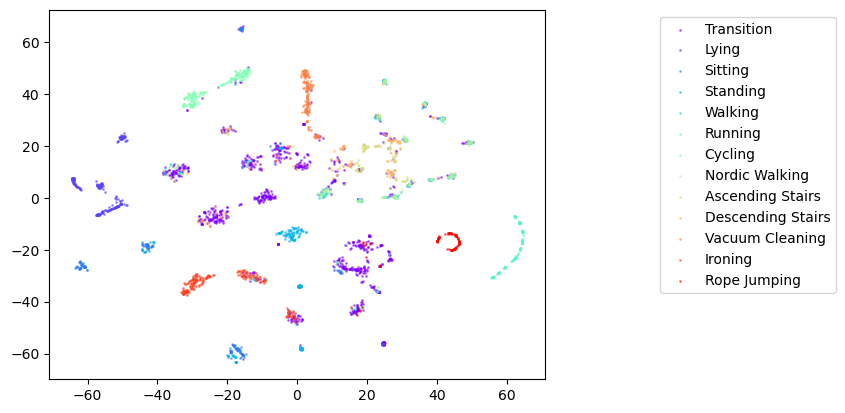

In [259]:
plt.style.use('default')
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]
?
clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['Transition',
                  'Lying',
                  'Sitting',
                  'Standing',
                  'Walking',
                  'Running',
                  'Cycling',
                  'Nordic Walking',
                  '8',
                  'Watching TV',
                  'Computer Work',
                  'Car Driving',
                  'Ascending Stairs',
                  'Descending Stairs',
                  '14',
                  '15',
                  'Vacuum Cleaning',
                  'Ironing',
                  'Folding Laundry',
                  'House Cleaning',
                  'Playing Soccer',
                  '21',
                  '22',
                  '23',
                  'Rope Jumping']

X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=0.5, s=1)

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

## Remove Duplicate Cluster Labels and Set Labels in Sequential Order

In [318]:
while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
    for assignment in range(np.max(cluster_assignments)+1):
        if assignment not in cluster_assignments:
            indx = np.where(cluster_assignments > assignment)
            cluster_assignments[indx] = cluster_assignments[indx]-1
    l = np.unique(cluster_assignments)

## Phase 3: Sldiing Window on Cluster Labels

In [311]:
window_length2 = 30
similarities = get_label_score(cluster_assignments, window_length2)


## Normalize and Smooth Sliding Window Distance

In [312]:
data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
data = smooth(np.blackman(50), data)

In [313]:
peaks, peak_data = find_peaks(data, height=0.6,distance=window_length2//2,prominence=0.1)
real_peaks = peaks+window_length2//2
predictions = get_changepoints(real_peaks, window_length, overlap_percent)


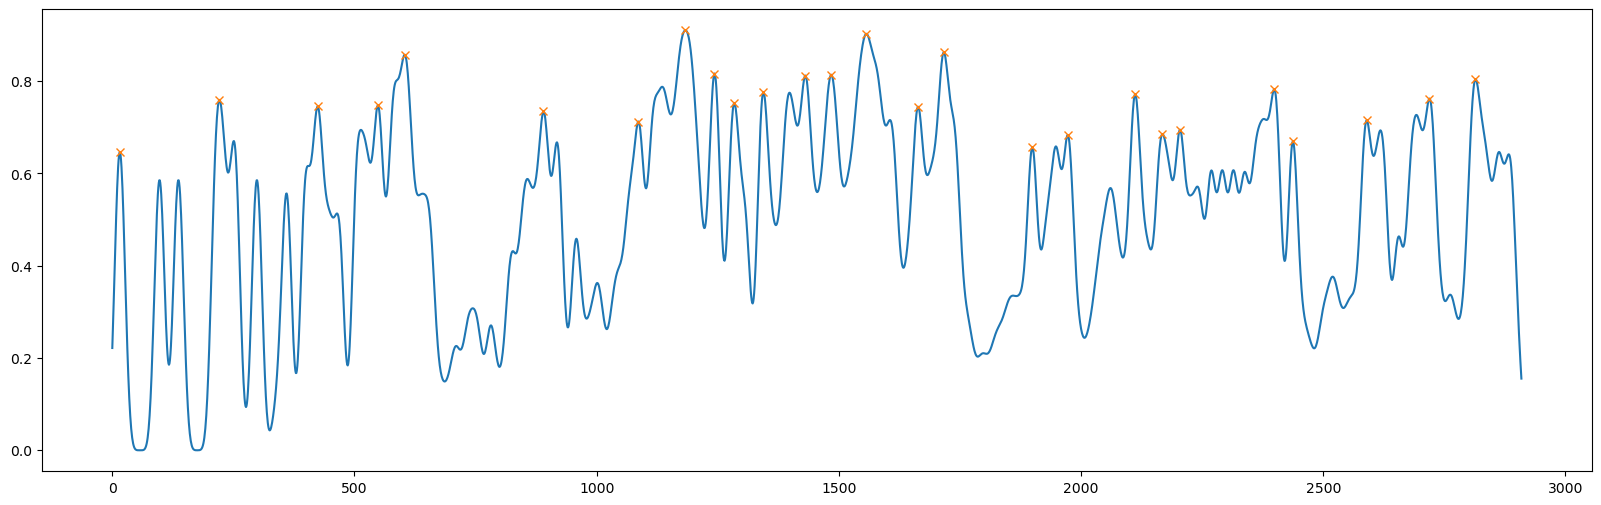

Space: Encoded Hidden Space
Clusters = 80


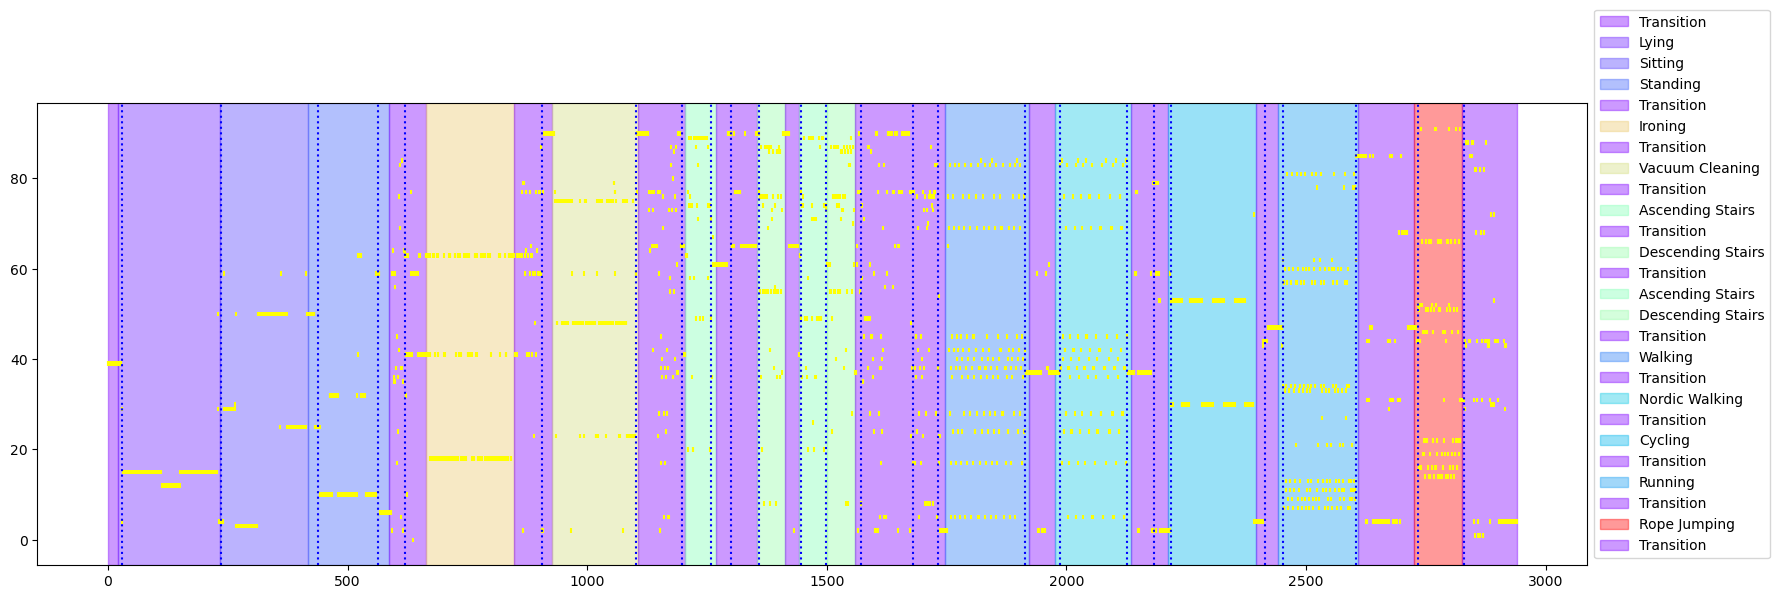

covering score: 0.774120841126022
margin: 3000
f_measure score: (0.830188679245283, 0.8148148148148148, 0.8461538461538461)


In [314]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
cmap = plt.get_cmap('rainbow')

l = np.unique(labels)


slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.show()

positions = np.arange(len(cluster_assignments))[:,np.newaxis]

plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])

for vline in real_peaks:
    plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

start = 0
subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = subsequence_ground_truth[i]

    plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
    plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
    start = end
plt.show()

print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 100*30
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))

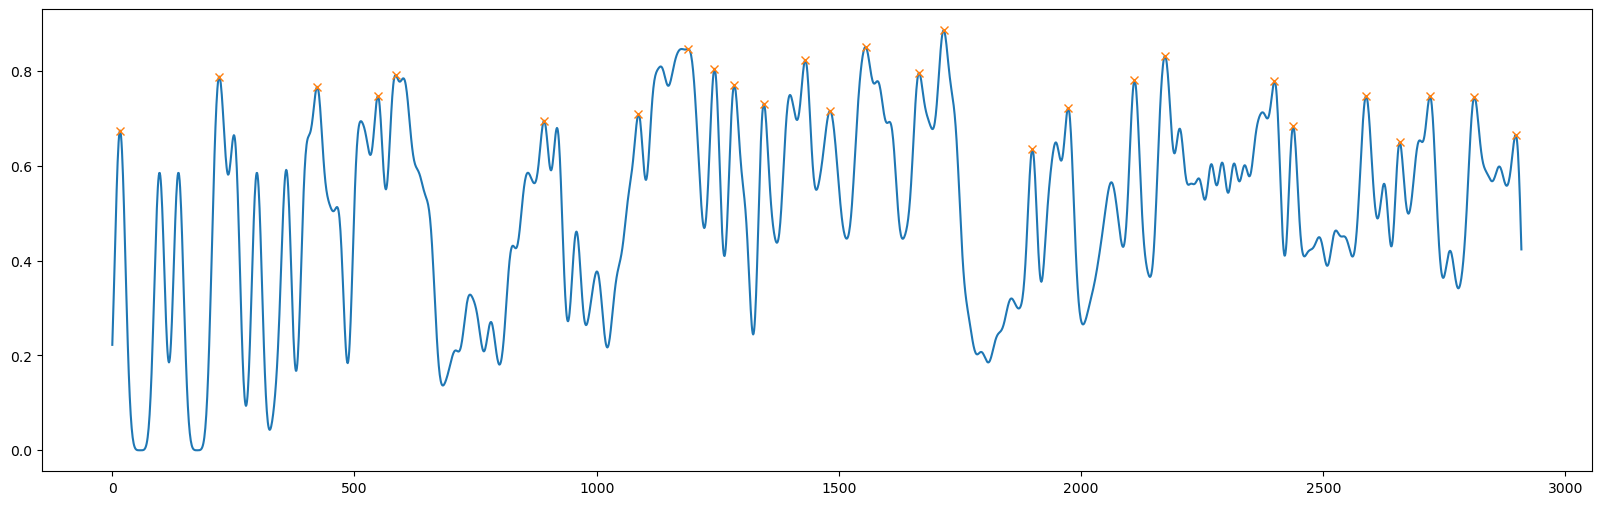

Space: Encoded Hidden Space
Clusters = 80


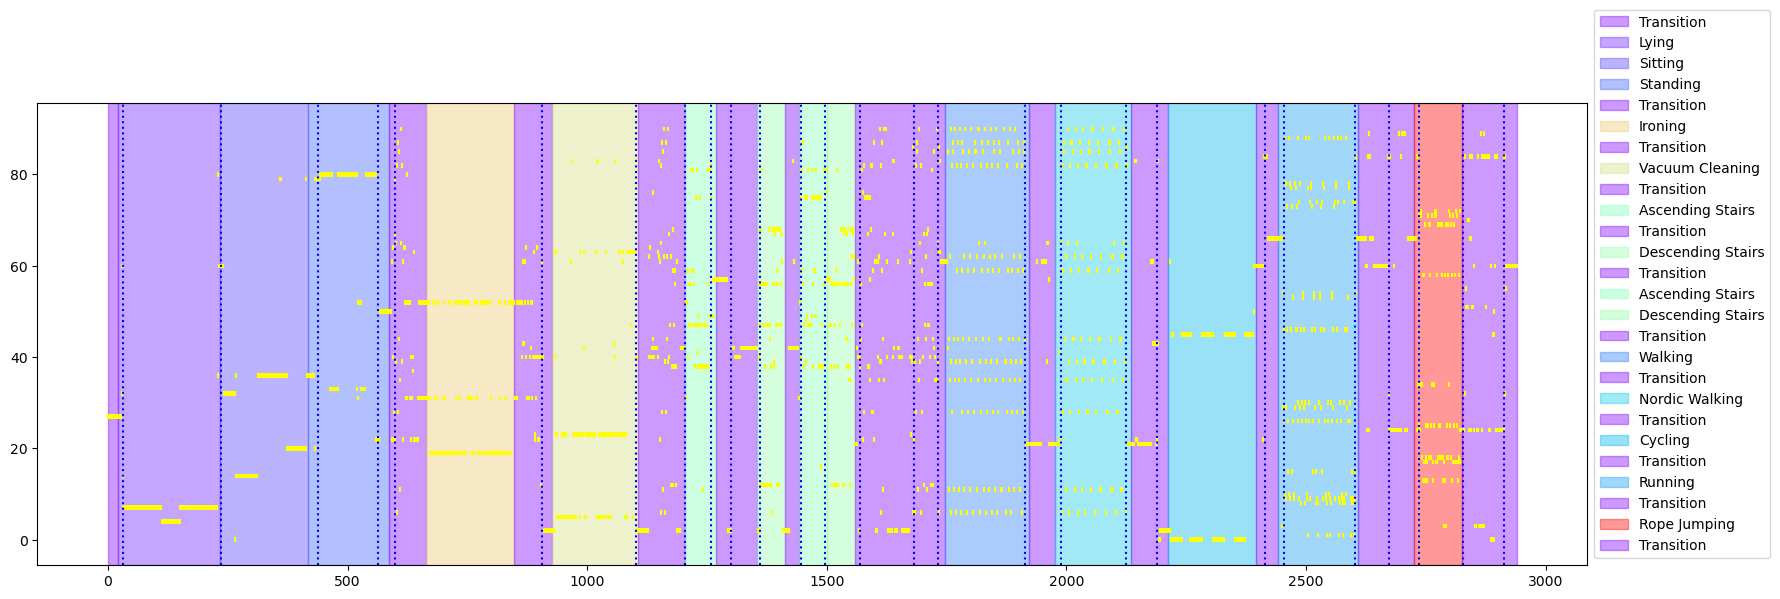

covering score: 0.7435906492676898
margin: 3000
f_measure score: (0.8518518518518519, 0.8214285714285714, 0.8846153846153846)


In [320]:
window_length2_list = np.arange(30,40,10)
for window_length2 in window_length2_list:
    similarities = get_label_score(cluster_assignments, window_length2)
    data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
    data = smooth(np.blackman(50), data)
    peaks, peak_data = find_peaks(data, height=0.6,distance=window_length2//2,prominence=0.1)
    real_peaks = peaks+window_length2//2
    predictions = get_changepoints(real_peaks, window_length, overlap_percent)
    plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
    cmap = plt.get_cmap('rainbow')

    l = np.unique(labels)


    slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


    plt.plot(data)
    plt.plot(peaks, data[peaks], "x")
    plt.show()

    positions = np.arange(len(cluster_assignments))[:,np.newaxis]

    plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])

    for vline in real_peaks:
        plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

    start = 0
    subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
    print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
    for i, activity in enumerate(activities):
        if i == len(activities):
            continue
        if i == len(activities)-1:
            end = len(subsequence_labels)
        else:
            end = subsequence_ground_truth[i]

        plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
        plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
        start = end
    plt.show()

    print('covering score:',covering(ground_truth, predictions, len(labels)))
    margin = 100*30
    print('margin:',margin)
    print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))